In [ ]:
# Reinstalar numpy en versión compatible
!pip install numpy==1.23.5 --quiet

# Reinstalar mediapipe para que se compile correctamente con esa versión
!pip install mediapipe --force-reinstall --no-cache-dir --quiet

# Reiniciar el kernel automáticamente (esto es necesario para que funcione correctamente)
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 36.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires

# 1. Cargar librerias

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


# 2. Cargar el dataset desde Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta al archivo zip en tu Google Drive
zip_path = '/content/drive/MyDrive/entrenamiento/dataset_combinado.zip'
extract_to = '/content'

In [ ]:
from zipfile import ZipFile

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset extraído en:", extract_to)

Dataset extraído en: /content


# 3. Extraer Landmarks de las manos

**Extrae los puntos de referencia de la mano para luego entrenar el modelo**

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm
import pickle
import os

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

X_data = []
y_labels = []

# Assuming the extracted dataset is in '/content/dataset_combinado'
dataset_path = "/content/dataset_combinado"

for letra in tqdm(letras, desc="📦 Procesando letras"):
    carpeta_letra = os.path.join(dataset_path, letra) # Updated path to include dataset_path
    if not os.path.exists(carpeta_letra):  # Check if the folder exists
        print(f"Warning: Folder for letter '{letra}' not found: {carpeta_letra}")
        continue
    for archivo in os.listdir(carpeta_letra):
        ruta_img = os.path.join(carpeta_letra, archivo)
        imagen = cv2.imread(ruta_img)
        if imagen is None:
            continue
        img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            coords = []
            for lm in results.multi_hand_landmarks[0].landmark:
                coords.extend([lm.x, lm.y, lm.z])
            X_data.append(coords)
            y_labels.append(letra)

X = np.array(X_data)
y = np.array(y_labels)

# Guardar los datos procesados para entrenamiento
with open("/content/features_mediapipe_static.pkl", "wb") as f:
    pickle.dump((X, y), f)

print("✅ Landmarks extraídos y guardados.")

📦 Procesando letras: 100%|██████████| 21/21 [05:51<00:00, 16.72s/it]

✅ Landmarks extraídos y guardados.


# 4. Generar el archivo CSV con los valores de landmarkers de las manos del paso anterior

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
dataset_path = "/content/dataset_combinado"
data = []

for letra in sorted(os.listdir(dataset_path)):
    letra_path = os.path.join(dataset_path, letra)
    if not os.path.isdir(letra_path):
        continue

    for archivo in tqdm(os.listdir(letra_path), desc=f"Procesando {letra}"):
        if not archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(letra_path, archivo)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resultado = hands.process(img_rgb)

        if resultado.multi_hand_landmarks:
            landmarks = resultado.multi_hand_landmarks[0]
            fila = []
            for lm in landmarks.landmark:
                fila.extend([lm.x, lm.y, lm.z])
            fila.append(letra)
            data.append(fila)

# Crear columnas para el DataFrame
n_landmarks = 21
columnas = [f"{eje}{i}" for i in range(n_landmarks) for eje in ['x', 'y', 'z']] + ['label']
df = pd.DataFrame(data, columns=columnas)

# Guardar el CSV
df.to_csv("/content/landmarks_dataset.csv", index=False)
print("✅ CSV guardado: /content/landmarks_dataset.csv")

Procesando y: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]


✅ CSV guardado: /content/landmarks_dataset.csv


# 5. Se carga el archivo CSV desde Google Drive

In [ ]:
ruta_csv = "/content/drive/MyDrive/entrenamiento/landmarks_dataset.csv"  # cambia la ruta si es necesario
df = pd.read_csv(ruta_csv)
df.head()

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,x18,y18,z18,x19,y19,z19,x20,y20,z20,label
0,0.746483,0.812821,1.727646e-07,0.729076,0.829353,-0.015229,0.727002,0.856446,-0.021602,0.727038,...,0.772116,0.907213,-0.006234,0.764955,0.925044,-0.008695,0.756194,0.935428,-0.009384,a
1,0.332596,0.763019,-5.350058e-08,0.346682,0.780655,-0.016082,0.351656,0.808172,-0.020138,0.354631,...,0.339672,0.848519,0.009689,0.349270,0.859242,0.007422,0.359101,0.865392,0.006251,a
2,0.527248,0.556146,-9.821353e-08,0.547490,0.537599,-0.002247,0.559696,0.510113,-0.004233,0.571788,...,0.507950,0.480342,-0.012722,0.515127,0.494038,-0.008768,0.515783,0.505039,-0.004613,a
3,0.716497,0.725687,7.545324e-08,0.700296,0.739350,-0.012339,0.695443,0.767569,-0.015118,0.693070,...,0.711641,0.805003,0.003300,0.701333,0.808909,0.001527,0.693629,0.806845,0.001110,a
4,0.403720,0.391323,-1.748886e-07,0.426222,0.370816,-0.001229,0.439416,0.337559,-0.001745,0.450197,...,0.397919,0.298596,-0.013454,0.400621,0.317100,-0.008595,0.397896,0.329742,-0.002992,a


# 6. Separar datos del dataset para entrenamiento y validacion

In [ ]:
# Separar las etiquetas (última columna)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Codificar las etiquetas (de letras a números)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Dividir entre entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y)

# 7. Aumenta los datos (Data Augmentation)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

**Como estamos trabajando con los landmarks entonces se puede aplicar un ligero aumento directamente sobre los valores de los landmarks antes de entrenar**

In [ ]:
def augment_landmarks(landmarks, noise_level=0.01):
    noise = np.random.normal(0, noise_level, size=landmarks.shape)
    return landmarks + noise

# 8. Normalizacion de los datos para mejorar el entrenamiento del modelo

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop('label', axis=1).values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 9. Diseño de la arquitectura neuronal del modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 10. Regularizacion de los datos para evitar el overfitting

In [ ]:
from tensorflow.keras.regularizers import l2

Dense(128, activation='relu', kernel_regularizer=l2(0.001))

<Dense name=dense_4, built=False>

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 11. Compilacion y entrenamiento del modelo

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0458 - loss: 3.0523 - val_accuracy: 0.0656 - val_loss: 3.0347
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0621 - loss: 3.0268 - val_accuracy: 0.0759 - val_loss: 2.9895
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0885 - loss: 2.9778 - val_accuracy: 0.1333 - val_loss: 2.8403
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1224 - loss: 2.8139 - val_accuracy: 0.1829 - val_loss: 2.6418
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1740 - loss: 2.6269 - val_accuracy: 0.2758 - val_loss: 2.3479
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2422 - loss: 2.3607 - val_accuracy: 0.3233 - val_loss: 2.1014
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3204 - loss: 2.1028 - val_accuracy: 0.4313 - val_loss: 1.8680
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3717 - loss: 1.9338 - val_accuracy: 0

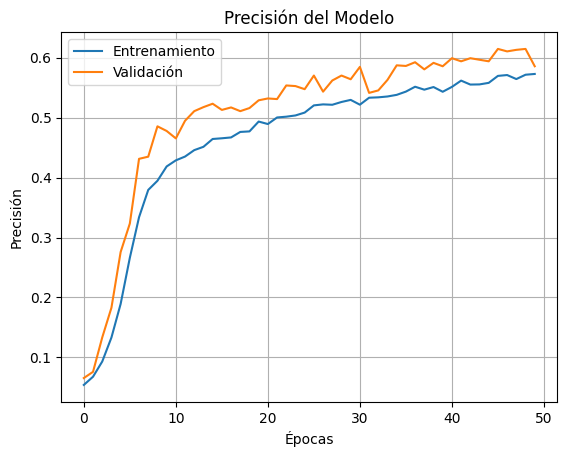

In [ ]:
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# 11. Guardar el modelo y las clases landmarks

In [ ]:
# Guardar el modelo
model.save('/content/modelo_lsc_mediapipe.h5')

# Guardar las clases
import pickle
with open('/content/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)